# Ideas

- investigate:
    - nbbo spread effect on customer size
    - nbbo spread effect on price
    - momentum
    - mean reversion
    - beta to esa, beta to other stocks
    - pairs trading

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [169]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# get statsmodels
import statsmodels.api as sm

# Config

In [80]:
_symbols = ["QQQ"]

## time
_num_ticks = 100000

## bbo generation
_bbo_size = 1000

_size_tick = 10
_price_tick = 0.01

In [81]:
np.random.seed(0)

In [82]:
def create_bbo(prices, fairs, symbol):
    # create dataframe
    df_bbo = pd.DataFrame({"tick": np.arange(_num_ticks), "price": prices, "fair": fairs})

    # create bbo data, size weighted
    df_bbo["symbol"] = symbol

    df_bbo["bid"] = round((df_bbo["price"] - _price_tick) / _price_tick) * _price_tick
    df_bbo["ask"] = round((df_bbo["price"] + _price_tick) / _price_tick) * _price_tick

    df_bbo["bidsz"] = _bbo_size * (df_bbo["price"] - df_bbo["bid"]) / _price_tick
    df_bbo["asksz"] = _bbo_size - df_bbo["bidsz"]

    clean_fn = lambda x : np.maximum(_size_tick, x // _size_tick * _size_tick).astype(int)
    df_bbo["bidsz"] = clean_fn(df_bbo["bidsz"])
    df_bbo["asksz"] = clean_fn(df_bbo["asksz"])
    
    # mid calculations
    df_bbo["mid"] = df_bbo.eval("(bid + ask) / 2")
    df_bbo["smid"] = df_bbo.eval("(bid * asksz + ask * bidsz) / (bidsz + asksz)")

    
    return df_bbo

In [83]:
## Create QQQs
# create time series data

def create_liquid_bbo(symbol, initial_price, fair_stdev):
    fair_chgs = np.random.normal(loc=0, scale=fair_stdev, size=_num_ticks)
    fairs = initial_price * np.exp(np.cumsum(fair_chgs))

    df_bbo = create_bbo(
        prices=fairs,
        fairs=fairs,
        symbol=symbol,
    )
    
    return df_bbo

In [84]:
# create index
df_index = create_liquid_bbo(
    symbol="QQQ",
    initial_price=100,
    fair_stdev=1e-4,
)

In [339]:
# create new bbos
# symbol = "Tech1"
# sym_beta = 2.5
# sym_initial_price = 1000
# sym_self_stdev = 1e-4
# sym_converge_rate = 0.02

def create_stock_bbo(symbol, df_index, beta, initial_price, fair_stdev, converge_rate):

    fair_chgs_self = np.random.normal(loc=0, scale=fair_stdev, size=_num_ticks)
    fairs_self = initial_price * np.exp(np.cumsum(fair_chgs_self))
    
    index_fair_chgs = np.log(df_index["fair"] / df_index["fair"].shift()).fillna(0)
    
    # compute fair from self-moves + index-moves
    fairs = fairs_self * np.exp(beta * np.cumsum(index_fair_chgs))

    # actual prices
    cur_price = initial_price
    prices = [cur_price]

    for tick in range(1, _num_ticks):
        # adjust to true fair
        cur_price = cur_price + (fairs[tick] - cur_price) * converge_rate
        prices += [cur_price]

    prices = np.array(prices)

    df_bbo = create_bbo(
        prices=prices,
        fairs=fairs,
        symbol=symbol,
    )
    
    return df_bbo

In [340]:
df_bbo_sym = create_stock_bbo(
    symbol="Tech1",
    df_index=df_index,
    beta=2.5,
    initial_price=1000,
    fair_stdev=1e-4,
    converge_rate=0.02,
)

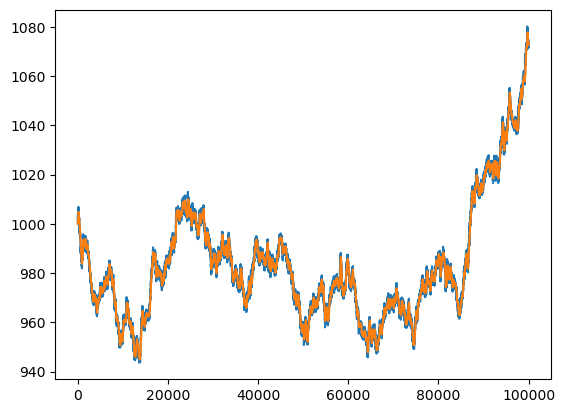

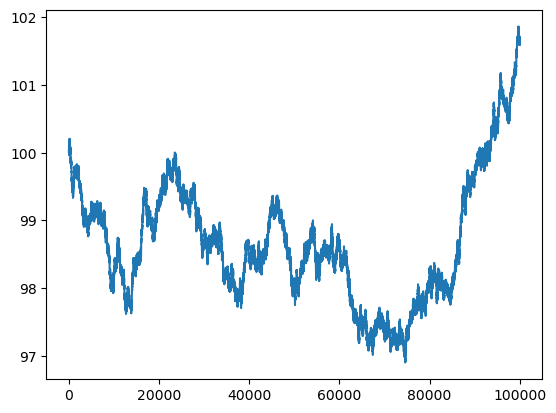

In [345]:
plt.plot(df_bbo_sym["fair"])
plt.plot(df_bbo_sym["price"])
plt.show()
plt.plot(df_index["fair"])

In [341]:
df_bbo_sym

,tick,price,fair,symbol,bid,ask,bidsz,asksz,mid,smid
0,0,1000.000000,1000.148642,Tech1,999.99,1000.01,990,10,1000.00,1000.009800
1,1,1000.004028,1000.201415,Tech1,999.99,1000.01,1400,10,1000.00,1000.009858
2,2,1000.015707,1000.587986,Tech1,1000.01,1000.03,570,420,1000.02,1000.021515
3,3,1000.040139,1001.237301,Tech1,1000.03,1000.05,1010,10,1000.04,1000.049804
4,4,1000.073521,1001.709219,Tech1,1000.06,1000.08,1350,10,1000.07,1000.079853
...,...,...,...,...,...,...,...,...,...,...
99995,99995,1072.705593,1072.614792,Tech1,1072.70,1072.72,550,440,1072.71,1072.711111
99996,99996,1072.694602,1072.156063,Tech1,1072.68,1072.70,1460,10,1072.69,1072.699864
99997,99997,1072.688911,1072.410048,Tech1,1072.68,1072.70,890,100,1072.69,1072.697980
99998,99998,1072.680558,1072.271280,Tech1,1072.67,1072.69,1050,10,1072.68,1072.689811


In [376]:
# get true betas
stock_chgs = np.log(df_bbo_sym["fair"].shift(-1) / df_bbo_sym["fair"]).fillna(0)
index_chgs = np.log(df_index["fair"].shift(-1) / df_index["fair"]).fillna(0)


In [382]:
X = index_chgs.to_numpy().reshape(len(index_chgs), 1)
y = np.array(stock_chgs)


model = LinearRegression(fit_intercept=False).fit(X, y)
beta = model.coef_[0]
r2 = model.score(X, y)

print("beta", beta)
print("r2", r2)


beta 2.499906473389959
r2 0.8617643983030872


In [560]:
""" HELPERS """
def create_windows(rng):
    rng = sorted(set(list(rng) + [0]))
    return [(rng[i], rng[i + 1]) for i in range(len(rng) - 1)]

def get_rtn_col(window):
    return f"rtn_{window[0]}_{window[1]}s"

def get_rtn_cols(windows):
    return [get_rtn_col(win) for win in windows]





def compute_marks(df_bbo, windows, mid_col):
    # init new df
    df_mark = df_bbo[["tick", "symbol", "mid", "smid"]].copy()

    # add marks for all mark_times
    for int_lb, int_ub in windows:
        ser1 = df_mark[mid_col].shift(-1 * int_lb)
        ser2 = df_mark[mid_col].shift(-1 * int_ub)
        df_mark[get_rtn_col((int_lb, int_ub))] = np.log(ser2 / ser1)

    df_mark = df_mark.dropna()
    return df_mark



In [613]:
pred_windows = [(-5, 0)]

resp_windows = create_windows(np.arange(0, 120 + 1, 5))
# create_windows(-1 * np.geomspace(1, 1200, 50).round().astype(int))


df_mark1 = compute_marks(
    df_bbo=df_index, 
    windows=pred_windows, 
    mid_col="mid",
)

df_mark2 = compute_marks(
    df_bbo=df_bbo_sym, 
    windows=resp_windows, 
    mid_col="mid",
)

df_mark1 = df_mark1.add_suffix("_pred")


In [615]:
df_mark1

,tick_pred,symbol_pred,mid_pred,smid_pred,rtn_-5_0s_pred
5,5,QQQ,100.06,100.069844,0.000400
6,6,QQQ,100.07,100.079837,0.000500
7,7,QQQ,100.07,100.079815,0.000400
8,8,QQQ,100.07,100.079596,0.000200
9,9,QQQ,100.07,100.079856,0.000000
...,...,...,...,...,...
99995,99995,QQQ,101.63,101.634747,0.000098
99996,99996,QQQ,101.61,101.613535,-0.000098
99997,99997,QQQ,101.61,101.619859,-0.000197
99998,99998,QQQ,101.60,101.609837,-0.000197


In [634]:
resp_win

(0, 5)

-5

-5

In [641]:
all_windows

[[(-5, 0)],
 [(0, 5),
  (5, 10),
  (10, 15),
  (15, 20),
  (20, 25),
  (25, 30),
  (30, 35),
  (35, 40),
  (40, 45),
  (45, 50),
  (50, 55),
  (55, 60),
  (60, 65),
  (65, 70),
  (70, 75),
  (75, 80),
  (80, 85),
  (85, 90),
  (90, 95),
  (95, 100),
  (100, 105),
  (105, 110),
  (110, 115),
  (115, 120)]]

In [662]:
# use various mark times

all_data = []

# get columns
xcols = list( pd.Series(get_rtn_cols(pred_windows)) + "_pred" )
ycols = get_rtn_cols(resp_windows)

# add_suffix + merge + dropna
df = df_mark1.merge(df_mark2, left_on="tick_pred", right_on="tick")
df = df.dropna()


all_data = []

for ycol, resp_win in zip(ycols, resp_windows):

    X = df[xcols]
    y = df[ycol]

    # indexes
    all_windows = [pred_windows, resp_win]
    keep_freq = max(np.max(wins) for wins in all_windows) - min(np.min(wins) for wins in all_windows)
    idxs = np.arange(0, len(X), keep_freq)
    X = X.iloc[idxs]
    y = y.iloc[idxs]

    model = LinearRegression(fit_intercept=False).fit(X, y)
    betas = model.coef_[0]

    ypred = model.predict(X)
#     r2s = r2_score(y, ypred, multioutput="raw_values")
    r2s = r2_score(y, ypred)
    
    # fit ols
    ols = sm.OLS(y, X).fit()
    tstat = ols.tvalues[xcols[0]]
    
    # betas
#     df_beta = pd.DataFrame({"beta": betas, "window": resp_windows})
#     df_beta["avg_window"] = -1 * df_beta["window"].apply(lambda x: (x[0] + x[1]) / 2)
#     df_beta

    
    all_data += [{"beta": betas, "r2": r2s, "tstat": tstat, "keep_freq": keep_freq, "resp_win1": resp_win[0], "resp_win2": resp_win[1], "avg_win": np.mean(resp_win)}]
    
#     display(ols.summary())
#     print(all_data)
#     break
    
df_beta = pd.DataFrame(all_data)
df_beta["abs_tstat"] = df_beta["tstat"].abs()

In [659]:
df_beta["tstat"]

,beta,r2,tstat,keep_freq,resp_win1,resp_win2,avg_win
0,0.218092,0.137754,40.044150,10,0,5,2.5
1,0.185335,0.096298,26.727401,15,5,10,7.5
2,0.185916,0.098983,23.495876,20,10,15,12.5
3,0.156170,0.072115,17.687391,25,15,20,17.5
4,0.144247,0.057063,14.257015,30,20,25,22.5
5,0.139829,0.058090,13.339651,35,25,30,27.5
6,0.132476,0.048571,11.345198,40,30,35,32.5
7,0.106844,0.032193,8.641622,45,35,40,37.5
8,0.096402,0.026812,7.474972,50,40,45,42.5
9,0.108178,0.035581,8.242885,55,45,50,47.5


r2 -0.0013884852125234382


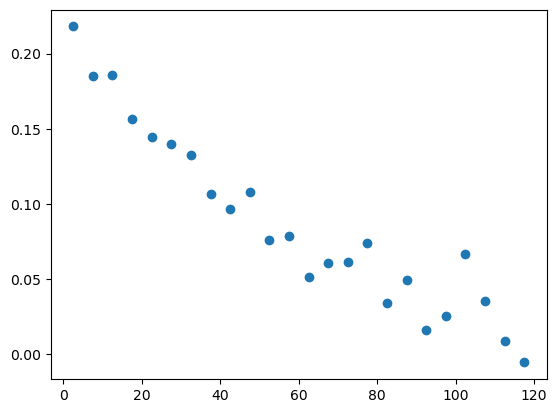

In [661]:
print("r2", r2s)
plt.scatter(df_beta["avg_win"], df_beta["beta"])
# plt.xscale('log')



In [585]:
from scipy.optimize import curve_fit

In [586]:
def exp_fn(x, a, b):
    return a * np.exp(b * x)

popt, pcov = curve_fit(exp_fn, df_beta["avg_window"], df_beta["beta"], p0=(-2.5, -0.1))
# popt, pcov = curve_fit(exp_fn, df_beta["avg_window"], np.maximum(df_beta["beta"], 0), p0=(-2.5, -0.1))
curve_fn = lambda x: exp_fn(x, *popt)


In [587]:
df_beta["beta_pred"] = curve_fn(df_beta["avg_window"])

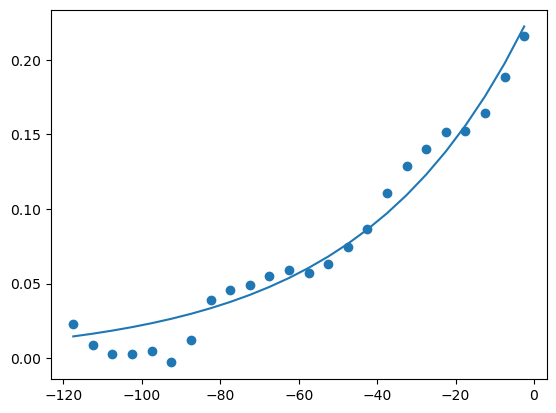

In [588]:
plt.scatter(df_beta["avg_window"], df_beta["beta"])
plt.plot(df_beta["avg_window"], df_beta["beta_pred"])
         

In [594]:
popt[0] / popt[1]

9.966874617704873

In [595]:
df_beta["beta"].sum()

1.832778505757656